In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from keras.models import Model, load_model, Sequential
import os
import cv2
from PIL import Image 
from tqdm import tqdm
from random import shuffle
import pickle
from keras import optimizers
from keras import applications

Mounted at /gdrive/


In [ ]:
# images = []
# for img, anno in tqdm(zip(os.listdir('../DeepFashion2_Dataset/train/train/image'), os.listdir('../DeepFashion2_Dataset/train/train/annos')), position = 0):
#     image = cv2.imread('../DeepFashion2_Dataset/train/train/image/' + img)
#     res = cv2.resize(image, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
#     images.append(res)
    

In [3]:
def create_label(number,vec_size):
    a=np.zeros((vec_size,1))
    a[number]=1
    return np.array(a)

def create_dataset_acs(IMG_SIZE=64,label_list=list(range(15))):
    #total images in training dataset=71094
    # mean image size 206,164
    DATASET_DIR='../fashion-data'
    DATASET_FILE_PATH='train.txt'

    train_file=open(os.path.join(DATASET_DIR,DATASET_FILE_PATH),'r')
    train_file_paths=train_file.read().split('\n')
    train_file.close()

    FILE_PATH='../fashion-data/labels.json'
    label_file=open(os.path.join(DATASET_DIR,FILE_PATH),'r')
    label_read=label_file.read()
    label_file.close()

    temp1=label_read.split('\n')
    label_file.close()

    labels_dict={}
    for i in temp1[1:-2]:
        key=i.split(':')
        if int(key[0]) in label_list:
            labels_dict[int(key[0])]=key[1][:-2]

    #IMG_SIZE=128
    training_data=[]
    k=0
    for img_path in tqdm(train_file_paths[:-1], position = 0 , desc = "Progress :"):
        k=k+1
        #img_path_full=os.path.join(DATASET_DIR+'/fashion-data/images',img_path+'.jpg')
        #img=cv2.imread(img_path_full,cv2.IMREAD_GRAYSCALE)
        #img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        
        #print(img)
        if int(img_path[0]) in label_list:
            img_path_full=os.path.join(DATASET_DIR+'/images',img_path+'.jpg')
            img=cv2.cvtColor(cv2.imread(img_path_full,cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB)
            img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
            label=create_label(int(img_path[0:2].split('/')[0]),len(label_list))
            training_data.append([np.array(img),label])
    
    shuffle(training_data)
    #np.save('acs_train_data_labels-{}.npy'.format(len(label_list)),training_data)
    return training_data,labels_dict

In [ ]:
training_data,labels_dict=create_dataset_acs()

Progress :: 100%|███████████████████████████████████████████████████████████████| 71093/71093 [05:28<00:00, 216.52it/s]


In [ ]:
# f = open("../Pickle-Data/ACS_training_data_64", "wb")
# pickle.dump(training_data, f)
# f.close()

In [ ]:
# f = open("../Pickle-Data/ACS_training_labels_dict_64", "wb")
# pickle.dump(labels_dict, f)
# f.close()

In [ ]:
training_data,labels_dict=create_dataset_acs(IMG_SIZE = 128)

Progress :: 100%|███████████████████████████████████████████████████████████████| 71093/71093 [01:35<00:00, 744.67it/s]


In [ ]:
# f = open("../Pickle-Data/ACS_training_data_128", "wb")
# pickle.dump(training_data, f)
# f.close()

In [ ]:
# f = open("../Pickle-Data/ACS_training_labels_dict_128", "wb")
# pickle.dump(labels_dict, f)
# f.close()

In [4]:
training_data,labels_dict=create_dataset_acs(IMG_SIZE = 50)

Progress :: 100%|███████████████████████████████████████████████████████████████| 71093/71093 [05:45<00:00, 205.86it/s]


In [5]:
# f = open("../Pickle-Data/ACS_training_data_50", "wb")
# pickle.dump(training_data, f)
# f.close()

In [6]:
# f = open("../Pickle-Data/ACS_training_labels_dict_50", "wb")
# pickle.dump(labels_dict, f)
# f.close()

In [3]:
# training_data = pickle.load(open('/gdrive/MyDrive/CSE344-Computer-Vision-Project/Clothing_Detection/ACS_training_data_64', 'rb'))
# labels_dict = pickle.load(open('/gdrive/MyDrive/CSE344-Computer-Vision-Project/Clothing_Detection/ACS_training_labels_dict_64', 'rb'))

training_data = pickle.load(open('../Pickle-Data/ACS_training_data_64', 'rb'))
labels_dict = pickle.load(open('../Pickle-Data//ACS_training_labels_dict_64', 'rb'))

In [4]:
#training data sanity check
print('# of training samples:',len(training_data),' shape:',training_data[0][0].shape,
      'shape_label:',training_data[0][1].shape)

# of training samples: 71093  shape: (64, 64, 3) shape_label: (15, 1)


In [5]:
train=training_data[:-3000]
val_test=training_data[-3000:]

In [6]:
X=np.array([np.array(i[0]) for i in train])
Y=np.array([i[1].reshape((len(labels_dict),)) for i in train])

val_test_x=np.array([np.array(i[0]) for i in val_test])
val_test_y=np.array([i[1].reshape((len(labels_dict),)) for i in val_test])

In [7]:
X.shape, Y.shape, val_test_x.shape, val_test_y.shape

((68093, 64, 64, 3), (68093, 15), (3000, 64, 64, 3), (3000, 15))

In [39]:
model=applications.VGG16(include_top=False,weights='imagenet',input_shape=(64,64,3),classes=len(labels_dict))

In [40]:

#setting trainable layers
for layer in model.layers:
    layer.trainable=True
# for layer in model.layers[:-8]:
#     layer.trainable=False



In [41]:
i=0
for layer in model.layers:
    i=i+1
    print('layer Number:',i,' setting:',layer.trainable)

layer Number: 1  setting: True
layer Number: 2  setting: True
layer Number: 3  setting: True
layer Number: 4  setting: True
layer Number: 5  setting: True
layer Number: 6  setting: True
layer Number: 7  setting: True
layer Number: 8  setting: True
layer Number: 9  setting: True
layer Number: 10  setting: True
layer Number: 11  setting: True
layer Number: 12  setting: True
layer Number: 13  setting: True
layer Number: 14  setting: True
layer Number: 15  setting: True
layer Number: 16  setting: True
layer Number: 17  setting: True
layer Number: 18  setting: True
layer Number: 19  setting: True


In [42]:
#extra FC layers
x=model.output
x=Flatten()(x)
x=Dense(1024,activation="relu")(x)
x=Dropout(0.2)(x)
# x=Dense(512,activation="relu")(x)
# x=Dropout(0.2)(x)
x=Dense(128,activation="relu")(x)
predictions=Dense(len(labels_dict),activation="softmax")(x)

In [43]:
model_final=Model(inputs=model.input,outputs=predictions)

In [44]:
model_final.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

In [45]:
rms=optimizers.RMSprop(lr=0.005)
model_final.compile(loss = "categorical_crossentropy", optimizer = rms, metrics=["accuracy"])

In [ ]:
history=model_final.fit(x=X,y=Y,epochs=20,validation_data=(val_test_x,val_test_y),batch_size=256)

Epoch 1/20
266/266 [==============================] - 78s 279ms/step - loss: 87824251694352.4219 - accuracy: 0.1250 - val_loss: 2.4805 - val_accuracy: 0.1197
Epoch 2/20
 77/266 [=======>......................] - ETA: 48s - loss: 2.4701 - accuracy: 0.1357

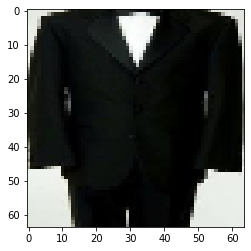

In [19]:
plt.imshow(X[0])